## **Temperature Forecasting**

El objetivo de la siguiente actividad es el de demostrar cómo se pueden usar modelos de Machine Learning en Series Temporales. Veremos que es necesaria cierta ingeniería de variables.



**Dataset**

The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data **from 1st January 2013 to 24th April 2017 in the city of Delhi, India**. 
The 4 parameters here are:

* meantemp
* humidity
* wind_speed
* meanpressure.



### **Lectura de datos**

Los datos vienen en dos archivos csv, uno con los de entrenamiento y el otro con los de test


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Master_UB_compartido/"
df_train = pd.read_csv(path+"DailyDelhiClimateTrain.csv", parse_dates=["date"])
print(df_train.shape)
df_train.head(2)

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.0,84.5,0.00,1015.666667
1,2013-01-02,7.4,92.0,2.98,1017.800000


In [ ]:
df_test = pd.read_csv(path+"DailyDelhiClimateTest.csv", parse_dates=["date"])
print(df_test.shape)
df_test.head(2)

(114, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778


### **Análisis Gráfico de los datos**

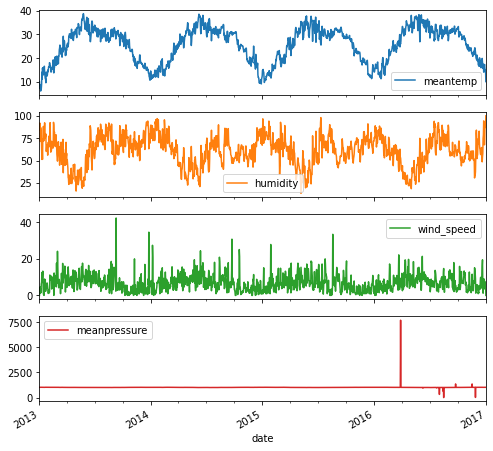

In [ ]:
df_train.set_index("date").plot(subplots=True, figsize=(8,8));

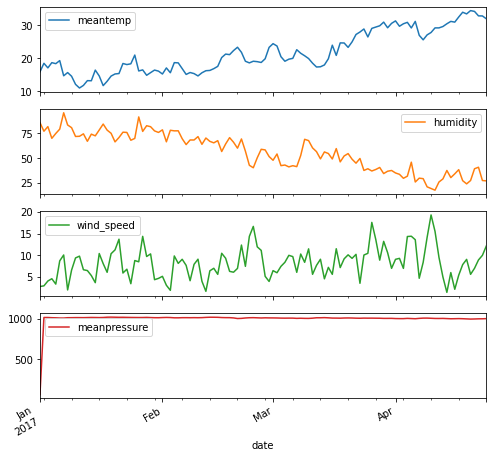

In [ ]:
df_test.set_index("date").plot(subplots=True, figsize=(8,8));

Como se puede observar, tanto en train como en test, los datos relativos a la media de la presión atmosférica tienen problemas de outliers.

Después de analizar los valores, podemos llegar a la conclusión de que filtrando por meanpressure = [980, 1100], conseguimos eliminar los outliers y ver el gráfico real

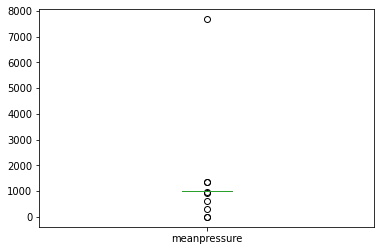

In [ ]:
df_train["meanpressure"].plot.box()

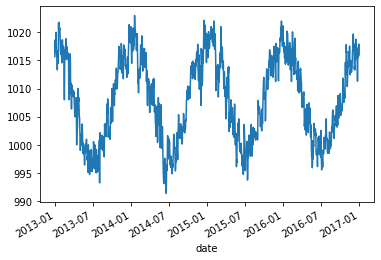

In [ ]:
df_train[df_train["meanpressure"].between(980,1100)].set_index("date")["meanpressure"].plot()

In [ ]:
df_train.loc[~df_train["meanpressure"].between(980,1100), "meanpressure"] = np.nan
df_train["meanpressure"].fillna(method="bfill", inplace=True)

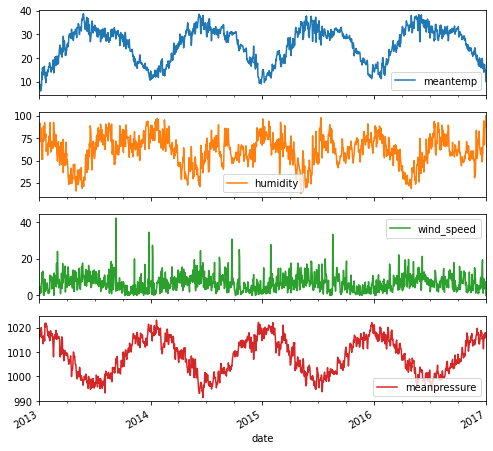

In [ ]:
df_train.set_index("date").plot(subplots=True, figsize=(8,8));

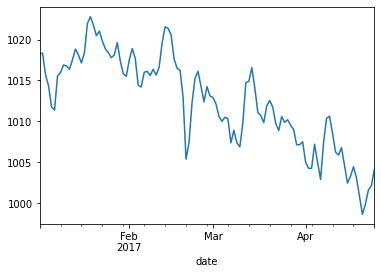

In [ ]:
df_test[df_test["meanpressure"].between(980,1100)].set_index("date")["meanpressure"].plot()

In [ ]:
df_test.loc[~df_test["meanpressure"].between(980,1100), "meanpressure"] = np.nan
df_test["meanpressure"].fillna(method="bfill", inplace=True)

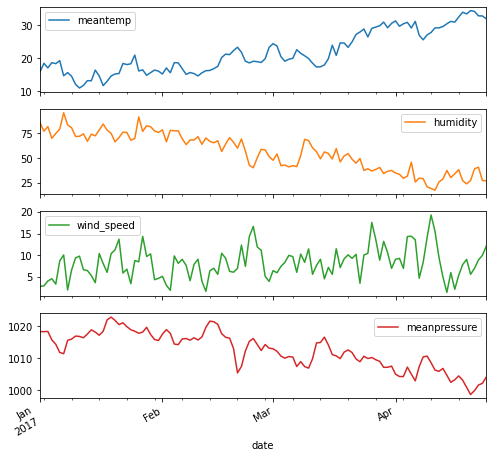

In [ ]:
df_test.set_index("date").plot(subplots=True, figsize=(8,8));

De los gráficos anteriores se puede ver que existe una relación inversa entre la presión atmosférica y la temperatura. Ocurre lo mismo con la humedad.



### **De serie temporal a datos para Machine Learning**

Se va a realizar un preprocesado en el que vamos a crear los campos necesarios para poder usar ML para forecasting. En nuestro caso, vamos a generar modelos diferentes que pretendan estimar la temperatura media de un día conociendo valores anteriores del resto de variables:

* Generación (usando .shift() de pandas) de las variables con los datos correspondientes a los dos días anteriores de humedad, velocidad del viento y presión atmosférica.

* Generación de variables relacionadas con la fecha: mes, semana y dia del año

Después uniremos todas estas variables para la creación de los modelos

#### **Preprocesado de Train**

In [ ]:
df_train2 = df_train[["meantemp", "humidity", "wind_speed", "meanpressure"]]
for col in df_train2.columns:
  if col != "meantemp":
    df_train2[col+"_1"] = df_train2[col].shift(1)
    df_train2[col+"_2"] = df_train2[col].shift(2)
    df_train2.drop(columns=[col], inplace=True)

In [ ]:
df_train2.head()

,meantemp,humidity_1,humidity_2,wind_speed_1,wind_speed_2,meanpressure_1,meanpressure_2
0,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,7.400000,84.500000,NaN,0.000000,NaN,1015.666667,NaN
2,7.166667,92.000000,84.5,2.980000,0.000000,1017.800000,1015.666667
3,8.666667,87.000000,92.0,4.633333,2.980000,1018.666667,1017.800000
4,6.000000,71.333333,87.0,1.233333,4.633333,1017.166667,1018.666667


In [ ]:
## Vamos a completar los NaN con los siguientes valores de cada campo.
df_train2.fillna(method="bfill", inplace=True)

In [ ]:
df_train2.head()

,meantemp,humidity_1,humidity_2,wind_speed_1,wind_speed_2,meanpressure_1,meanpressure_2
0,10.000000,84.500000,84.5,0.000000,0.000000,1015.666667,1015.666667
1,7.400000,84.500000,84.5,0.000000,0.000000,1015.666667,1015.666667
2,7.166667,92.000000,84.5,2.980000,0.000000,1017.800000,1015.666667
3,8.666667,87.000000,92.0,4.633333,2.980000,1018.666667,1017.800000
4,6.000000,71.333333,87.0,1.233333,4.633333,1017.166667,1018.666667


In [ ]:
df_train3 = pd.DataFrame({"month": df_train["date"].dt.month, "week":df_train["date"].dt.week, "day":df_train["date"].dt.dayofyear})
df_train3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


,month,week,day
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,1,5
...,...,...,...
1457,12,52,363
1458,12,52,364
1459,12,52,365
1460,12,52,366


In [ ]:
df_train2 = pd.concat([df_train2, df_train3], axis=1)
df_train2.head()

,meantemp,humidity_1,humidity_2,wind_speed_1,wind_speed_2,meanpressure_1,meanpressure_2,month,week,day
0,10.000000,84.500000,84.5,0.000000,0.000000,1015.666667,1015.666667,1,1,1
1,7.400000,84.500000,84.5,0.000000,0.000000,1015.666667,1015.666667,1,1,2
2,7.166667,92.000000,84.5,2.980000,0.000000,1017.800000,1015.666667,1,1,3
3,8.666667,87.000000,92.0,4.633333,2.980000,1018.666667,1017.800000,1,1,4
4,6.000000,71.333333,87.0,1.233333,4.633333,1017.166667,1018.666667,1,1,5


#### **Preprocesado de Test**

In [ ]:
df_test2 = df_test[["meantemp", "humidity", "wind_speed", "meanpressure"]]
for col in df_test2.columns:
  if col != "meantemp":
    df_test2[col+"_1"] = df_test2[col].shift(1)
    df_test2[col+"_2"] = df_test2[col].shift(2)
    df_test2.drop(columns=[col], inplace=True)

In [ ]:
## Vamos a completar los NaN con los siguientes valores de cada campo.
df_test2.fillna(method="bfill", inplace=True)

In [ ]:
df_test3 = pd.DataFrame({"month": df_test["date"].dt.month, "week":df_test["date"].dt.week, "day":df_test["date"].dt.dayofyear})
df_test2 = pd.concat([df_test2, df_test3], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df_test2.head()

,meantemp,humidity_1,humidity_2,wind_speed_1,wind_speed_2,meanpressure_1,meanpressure_2,month,week,day
0,15.913043,85.869565,85.869565,2.743478,2.743478,1018.277778,1018.277778,1,52,1
1,18.500000,85.869565,85.869565,2.743478,2.743478,1018.277778,1018.277778,1,1,2
2,17.111111,77.222222,85.869565,2.894444,2.743478,1018.277778,1018.277778,1,1,3
3,18.700000,81.888889,77.222222,4.016667,2.894444,1018.333333,1018.277778,1,1,4
4,18.388889,70.050000,81.888889,4.545000,4.016667,1015.700000,1018.333333,1,1,5


### **X_train, y_train, X_test, y_test**

In [ ]:
X_train = df_train2.iloc[:,1:]
y_train = df_train2["meantemp"]

X_test = df_test2.iloc[:,1:]
y_test = df_test2["meantemp"]

### **Árboles de Decisión**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=0, max_depth=2)
tree_model.fit(X_train, y_train)
pred_train = tree_model.predict(X_train)
pred_test = tree_model.predict(X_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*tree_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*tree_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 79.12
Precisión sobre los datos de test: 67.51


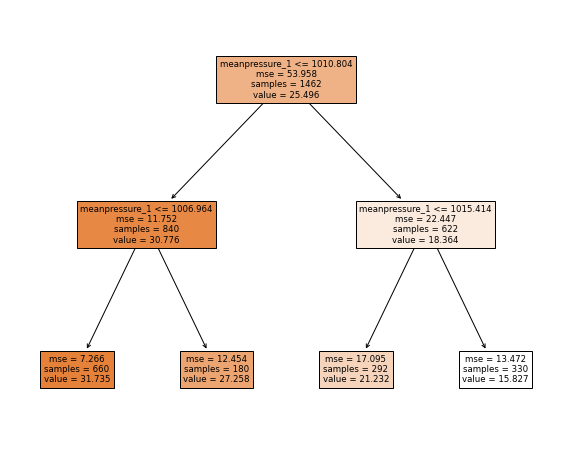

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
plt.figure(figsize=(10,8))
plot_tree(tree_model, filled=True, max_depth=2,feature_names=X_test.columns)
plt.show()

### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(max_depth=3, random_state=0, n_jobs=3, n_estimators=10)
rf_model.fit(X_train,y_train)

pred_train_rf = rf_model.predict(X_train)
pred_test_rf = rf_model.predict(X_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*rf_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 88.68
Precisión sobre los datos de test: 72.24


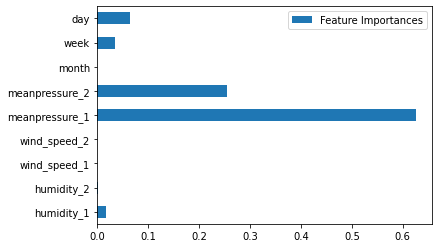

In [ ]:
df_imp = pd.DataFrame(rf_model.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

### **Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=0, n_estimators=50, max_depth=1, learning_rate=0.5)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.5, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
pred_test_gb = gb_model.predict(X_test)
pred_train_gb = gb_model.predict(X_train)

In [ ]:
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*gb_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*gb_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 90.85
Precisión sobre los datos de test: 69.64


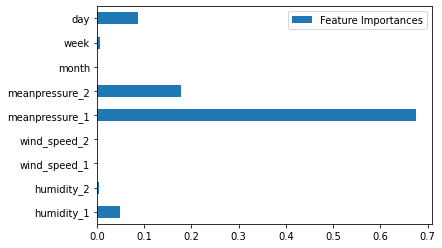

In [ ]:
df_imp = pd.DataFrame(gb_model.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

In [ ]:
df_train["date"].values

array(['2013-01-01T00:00:00.000000000', '2013-01-02T00:00:00.000000000',
       '2013-01-03T00:00:00.000000000', ...,
       '2016-12-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

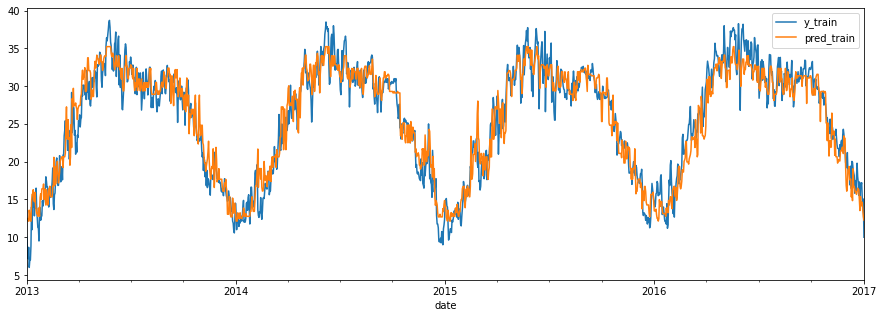

In [ ]:
df_train_pred = pd.DataFrame({"y_train":y_train.values, "pred_train":pred_train_gb, "date":df_train["date"].values})
df_train_pred.set_index("date").plot(figsize=(15,5))

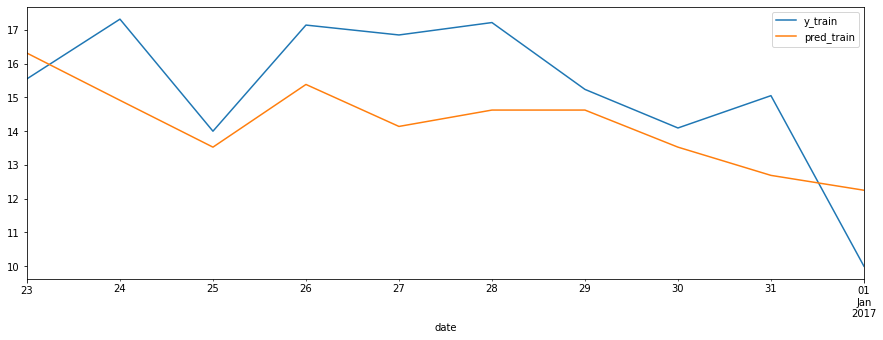

In [ ]:
df_train_pred.set_index("date").iloc[-10:,:].plot(figsize=(15,5))

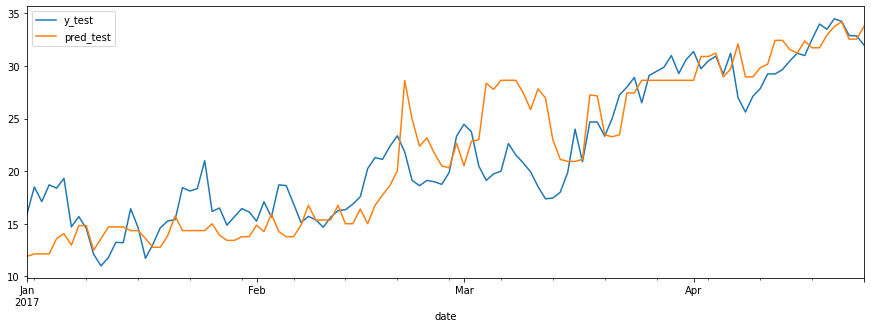

In [ ]:
df_test_pred = pd.DataFrame({"y_test":y_test.values, "pred_test":pred_test_gb, "date":df_test["date"].values})
df_test_pred.set_index("date").plot(figsize=(15,5))

### **AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ada_model = AdaBoostRegressor(random_state=0, n_estimators=50, learning_rate=0.05)
ada_model.fit(X_train, y_train)
pred_train_ada = ada_model.predict(X_train)
pred_test_ada = ada_model.predict(X_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*ada_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*ada_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 88.42
Precisión sobre los datos de test: 71.09


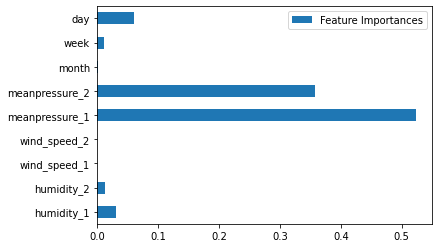

In [ ]:
df_imp = pd.DataFrame(ada_model.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

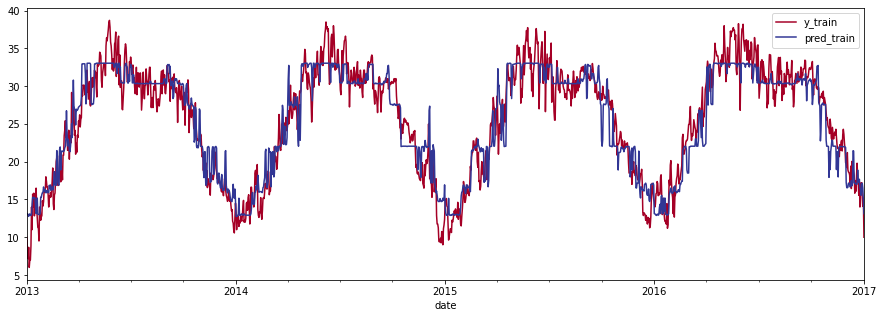

In [ ]:
df_train_pred = pd.DataFrame({"y_train":y_train.values, "pred_train":pred_train_ada, "date":df_train["date"].values})
df_train_pred.set_index("date").plot(cmap=plt.cm.RdYlBu, figsize=(15,5))

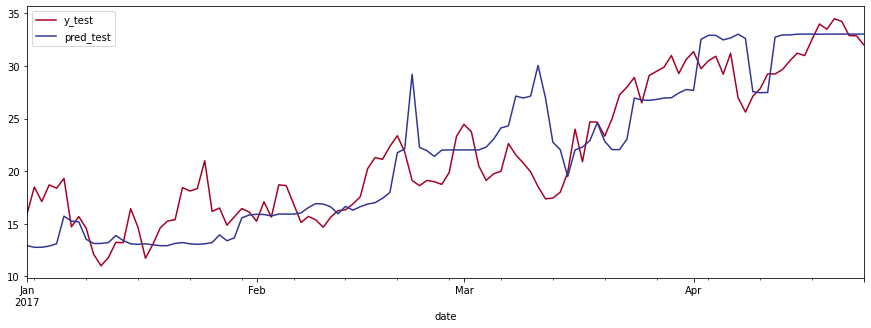

In [ ]:
df_test_pred = pd.DataFrame({"y_test":y_test.values, "pred_test":pred_test_ada, "date":df_test["date"].values})
df_test_pred.set_index("date").plot(cmap=plt.cm.RdYlBu,figsize=(15,5))

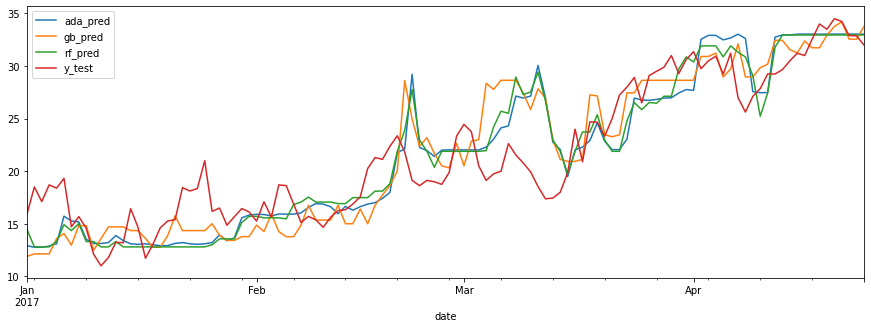

In [ ]:
df_compare = pd.DataFrame({"ada_pred":pred_test_ada,"gb_pred":pred_test_gb,"rf_pred":pred_test_rf, "y_test":y_test, "date":df_test["date"].values})
df_compare.set_index("date").plot(figsize=(15,5));

### **Análisis de los errores de Marzo**

Vamos a centrarnos en la zona de comienzos de marzo donde existen errores importantes en todos los modelos de ensamblado.

Dada la importancia de la presión atmosférica se lleva a cabo un análisis de su comportamiento respecto a la temperatura

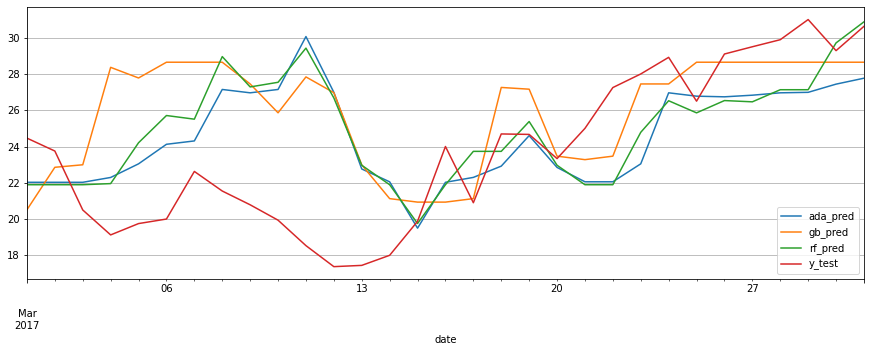

In [ ]:
df_compare.set_index("date")["03-2017"].plot(figsize=(15,5), grid=True);

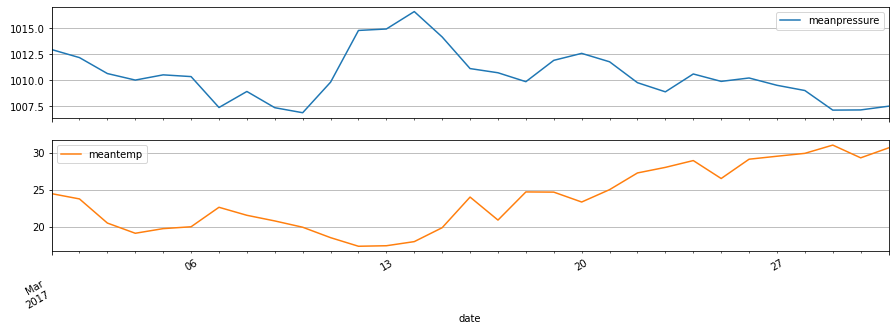

In [ ]:
df_test[["date", "meanpressure","meantemp"]].set_index("date")["03-2017"].plot(figsize=(15,5), grid=True, subplots=True);

Se puede ver cómo hasta el día 13 de marzo ambas curvas hacen un movimiento descendente cuando lo normal es que hagan movimientos inversos.

A partir de ese día el modelo funciona mejor porque la temperatura sube al tiempo que baja la presión atmosférica.

### **Comparativa de errores entre modelos** 

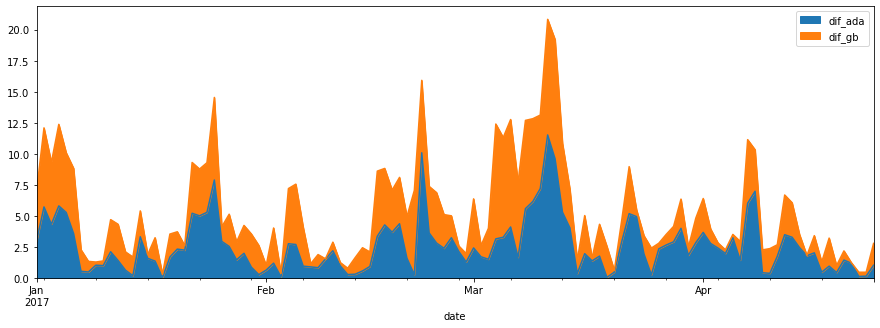

In [ ]:
df_compare_dif = pd.DataFrame({"dif_ada":np.abs(y_test - pred_test_ada),"dif_gb":np.abs(y_test - pred_test_gb), "date":df_test["date"].values})
df_compare_dif.set_index("date").plot.area(figsize=(15,5))

In [ ]:
from sklearn.metrics import mean_squared_error
print (mean_squared_error(y_test, pred_test))
print (mean_squared_error(y_test, pred_test_rf))
print (mean_squared_error(y_test, pred_test_gb))
print (mean_squared_error(y_test, pred_test_ada))

13.02564259881238
11.129504564862296
12.17213564756872
11.59159397364759


In [ ]:
from sklearn.metrics import mean_absolute_error
print (mean_absolute_error(y_test, pred_test))
print (mean_absolute_error(y_test, pred_test_rf))
print (mean_absolute_error(y_test, pred_test_gb))
print (mean_absolute_error(y_test, pred_test_ada))

2.7130247748727085
2.561166423974518
2.6334863041920866
2.612064053867155


Se puede ver que hay un error medio absoluto de entre 2.5 y 3 grados a lo largo de todo el test-set.

Con los parámetros que se han dado a los diferentes modelos, el que mejor comportamiento tiene es Random Forest